In [1]:
# =========================================================
# 1️⃣  IMPORTS AND PARAMETERS
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# --------------------------
# Parameters
# --------------------------
row_nan_threshold = 0.2   # Drop rows with >20% missing predictors
col_nan_threshold = 0.5   # Drop predictors with >50% missing values
impute_strategy = 'median'  # 'median' or 'mean'
placeholder_values = [-9999, -9999.0, np.inf, -np.inf]  # values to treat as NaN
target_col = 'log_soc_stock'  # target variable
force_keep = ['site_info_id', 'annual_mean_temp', 'temp_annual_range', 'temp_seasonality', 'max_temp_warmest_month', 'annual_precip', 'tmax_mean_mean', 'twi', 'MRVBF', 'terrain_surf_convexity', 'terrain_surf_texture', 'normalized_height', 'slope_height', 'litho_value', 'max_temp_warmest_month','standardized_height', 'temp_annual_range'
]

input_path = "/Users/inesschwartz/Desktop/training_data.csv"
output_path = "/Users/inesschwartz/Desktop/intermediate_dataset.csv"

In [2]:
# =========================================================
# 2️⃣  LOAD AND INITIAL CLEANUP
# =========================================================
df = pd.read_csv(input_path)
df.replace(placeholder_values, np.nan, inplace=True)

print(f"✅ Loaded {df.shape[0]} rows and {df.shape[1]} columns")

# =========================================================
# 3️⃣  DROP EXCESSIVELY MISSING COLUMNS
# =========================================================
predictor_cols = df.select_dtypes(include='number').columns.drop(target_col)
missing_pct_cols = df[predictor_cols].isna().mean()
cols_to_keep = missing_pct_cols[missing_pct_cols <= col_nan_threshold].index

# force keep important predictors
cols_to_keep = cols_to_keep.union([c for c in force_keep if c in df.columns])

cols_dropped = [c for c in predictor_cols if c not in cols_to_keep]

print(f"\nDropped {len(cols_dropped)} columns (> {col_nan_threshold*100:.0f}% missing):")
print(cols_dropped)

df_cleaned = df[[target_col] + list(cols_to_keep)].copy()

✅ Loaded 926 rows and 89 columns

Dropped 0 columns (> 50% missing):
[]


In [3]:
# =========================================================
# 4️⃣  DROP ROWS WITH TOO MANY NaNs
# =========================================================
predictor_cols_cleaned = cols_to_keep
max_missing_per_row = int(row_nan_threshold * len(predictor_cols_cleaned))
rows_missing_count = df_cleaned[predictor_cols_cleaned].isna().sum(axis=1)
rows_to_keep = rows_missing_count <= max_missing_per_row
rows_dropped_count = (~rows_to_keep).sum()

df_cleaned = df_cleaned[rows_to_keep].copy()

print(f"\nDropped {rows_dropped_count} rows with > {row_nan_threshold*100:.0f}% missing predictors")

# =========================================================
# 5️⃣  IMPUTE REMAINING MISSING VALUES
# =========================================================
imputer = SimpleImputer(strategy=impute_strategy)

n_missing_before = df_cleaned[predictor_cols_cleaned].isna().sum().sum()
df_cleaned[predictor_cols_cleaned] = imputer.fit_transform(df_cleaned[predictor_cols_cleaned])
n_missing_after = df_cleaned[predictor_cols_cleaned].isna().sum().sum()

print(f"\n✅ Imputed {n_missing_before - n_missing_after} missing values using {impute_strategy} strategy")

# sanity check
print("\nNaN check after imputation:")
print(df_cleaned[['annual_mean_temp', 'temp_annual_range']].isna().sum())

# =========================================================
# 6️⃣  SAVE CLEANED DATASET
# =========================================================
df_cleaned.to_csv(output_path, index=False)
print(f"\n💾 Cleaned dataset saved to: {output_path}")


Dropped 19 rows with > 20% missing predictors

✅ Imputed 559 missing values using median strategy

NaN check after imputation:
annual_mean_temp     0
temp_annual_range    0
temp_annual_range    0
dtype: int64

💾 Cleaned dataset saved to: /Users/inesschwartz/Desktop/intermediate_dataset.csv


In [4]:
# =========================================================
# 7️  DEFINE WORKING DATAFRAMES FOR ANALYSIS
# =========================================================
df1 = df_cleaned.copy()        # main working dataset
df1.describe()    # numeric summary

,log_soc_stock,MRRTF,MRVBF,X_coord,Y_coord,annual_mean_temp,annual_precip,aspect,aspect_cos,aspect_sin,...,tot_rainfed_1950,tot_rainfed_1960,tot_rice_1950,tot_rice_1960,total_curve,twi,valley_depth,valley_index,watershed_basins,year
count,907.000000,907.000000,907.000000,9.070000e+02,9.070000e+02,9.070000e+02,907.000000,907.000000,907.000000,907.000000,...,907.000000,907.000000,907.000000,907.000000,9.070000e+02,907.000000,907.000000,907.000000,907.000000,907.000000
mean,1.188400,4.970241,7.070763,6.047536e+05,8.800540e+06,-5.252429e+36,1077.412348,3.181556,0.081999,-0.051559,...,2.657999,3.114295,0.025344,0.028777,8.071462e-10,5.167817,141.646717,0.001103,4484.799338,1960.355017
std,0.536460,2.587414,2.807293,2.735350e+05,3.496315e+05,4.197217e+37,295.545311,1.898742,0.701014,0.707312,...,3.440829,4.041632,0.420890,0.504933,3.029172e-09,1.228265,94.208017,0.033204,1761.105257,3.448723
min,0.000000,0.003416,0.004130,1.806169e+05,7.998325e+06,-3.402823e+38,40.000000,0.000992,-1.000000,-0.999996,...,0.000000,0.000000,0.000000,0.000000,5.709472e-14,1.543413,41.331638,0.000000,0.000000,1946.000000
25%,0.866063,2.911972,4.822731,3.917612e+05,8.549970e+06,2.018010e+01,908.000000,1.408055,-0.616200,-0.761887,...,0.460496,0.555427,0.000000,0.000000,5.563011e-11,4.630390,79.816574,0.000000,3363.000000,1957.000000
50%,1.174506,5.815787,8.715154,5.855401e+05,8.746338e+06,2.176585e+01,1208.000000,3.337239,0.168186,-0.078099,...,1.447530,1.678322,0.000000,0.000000,1.966796e-10,5.050433,104.535568,0.000000,4340.000000,1960.000000
75%,1.513178,6.981865,8.828290,7.428015e+05,9.078255e+06,2.335018e+01,1291.000000,4.878815,0.772244,0.641657,...,3.235534,3.816146,0.000000,0.000000,5.391137e-10,5.392208,179.058144,0.000000,5690.000000,1963.000000
max,3.590526,8.759588,8.976939,1.482544e+06,9.500310e+06,2.750000e+01,1597.000000,6.281015,1.000000,0.999807,...,19.946777,22.301388,7.955687,9.657352,7.151091e-08,10.878047,563.903748,1.000000,7794.000000,1967.000000


In [5]:
print("\n✅ Data ready for analysis. Shape:", df1.shape)


✅ Data ready for analysis. Shape: (907, 88)


In [6]:
## outliers, 0s, nans

import pandas as pd
import numpy as np

# Select numeric columns
numeric_cols = df1.select_dtypes(include=[np.number]).columns

# Initialize results dictionary
summary = {}

for col in numeric_cols:
    data = df[col]
    
    # Count NaNs
    n_nan = data.isna().sum()
    
    # Count zeros
    n_zero = (data == 0).sum()
    
    # Detect outliers using 1.5*IQR rule
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    n_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    
    # Store results
    summary[col] = {
        "NaN_count": n_nan,
        "Zero_count": n_zero,
        "Outlier_count": n_outliers
    }

# Convert results to a DataFrame for easy viewing
summary_df = pd.DataFrame(summary).T  # transpose for readability
summary_df = summary_df.sort_values(by="Outlier_count", ascending=False)

# Display results
print(summary_df)

                           NaN_count  Zero_count  Outlier_count
formation                          0           1            256
flowline_curve                     4           0            229
precip_driest_month               25         756            145
litho_value                        0           7            119
landsurface_value                  0           7            116
...                              ...         ...            ...
site_info_id                       0           0              0
rangeland_1960                    13         443              0
rangeland_1950                    18         415              0
mean_temp_coldest_quarter         25           0              0
flow_directions                    4         246              0

[86 rows x 3 columns]


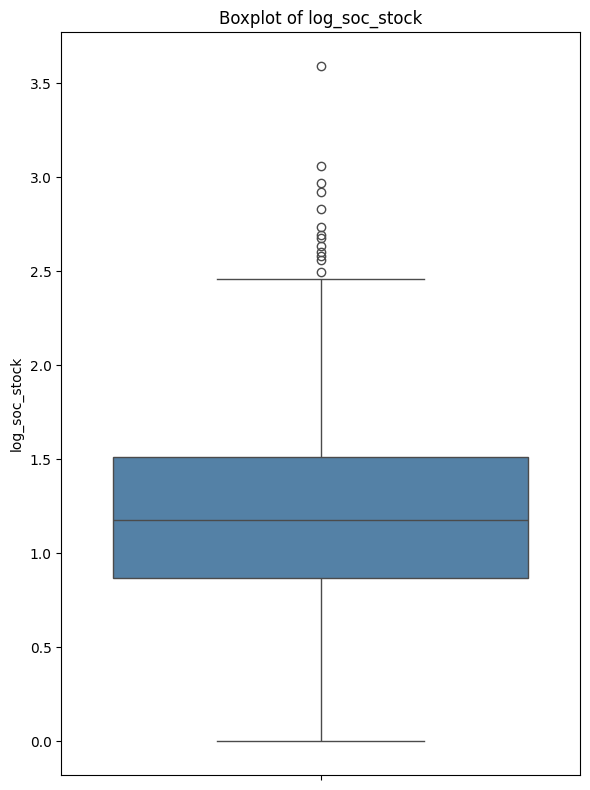

In [7]:
# =========================================================
# 9️⃣  VISUAL CHECKS
# =========================================================
plt.figure(figsize=(6,8))
sns.boxplot(y=df1['log_soc_stock'], color='steelblue')
plt.title('Boxplot of log_soc_stock')
plt.tight_layout()
plt.show()

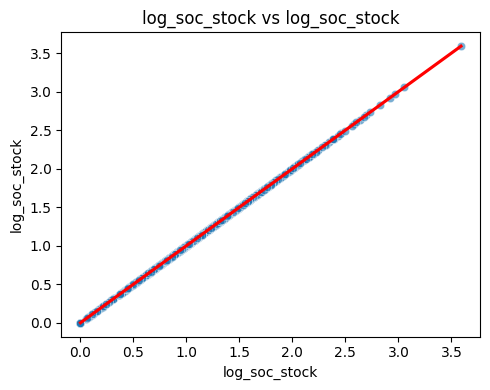

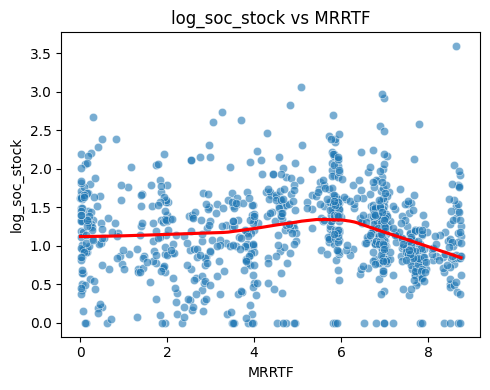

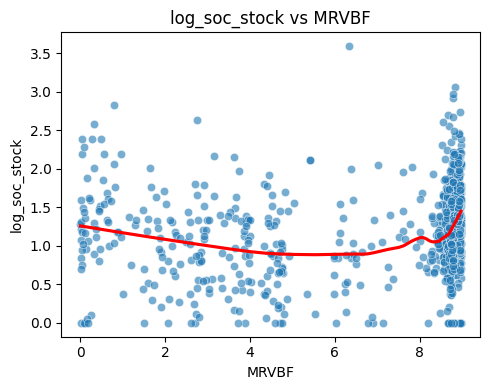

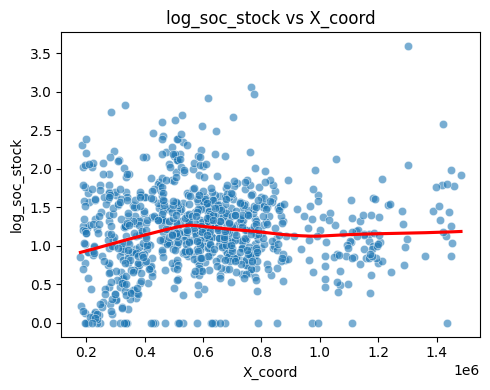

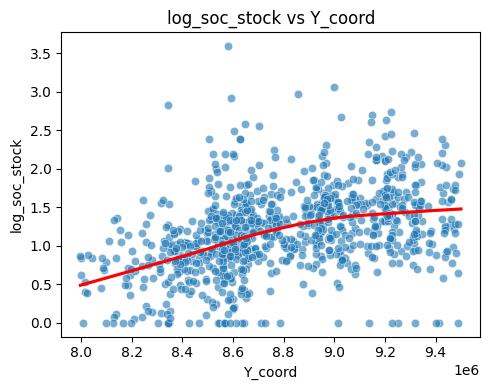

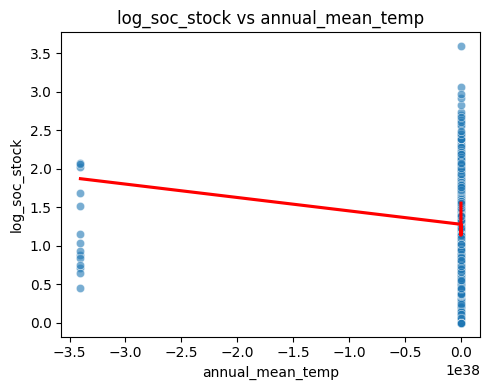

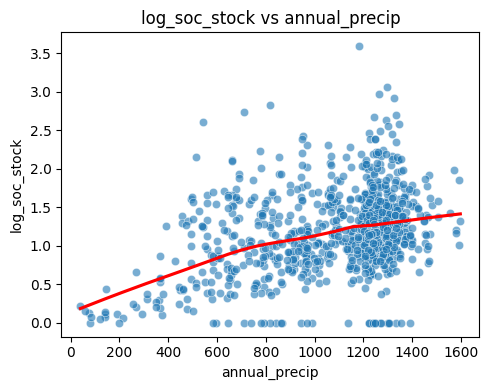

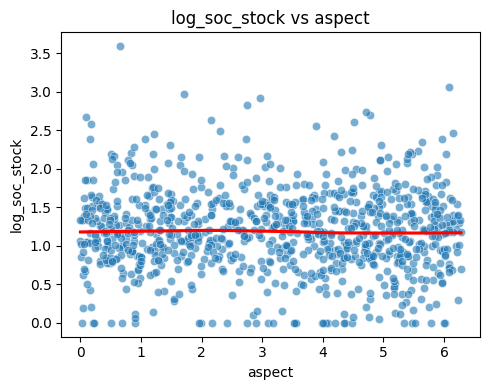

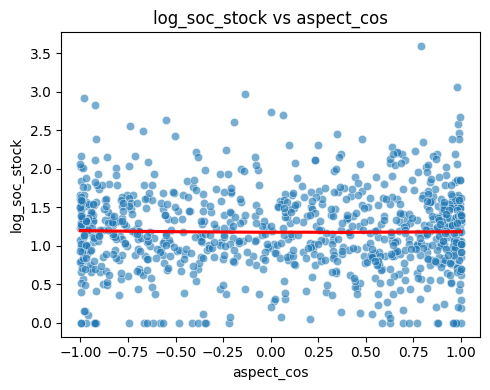

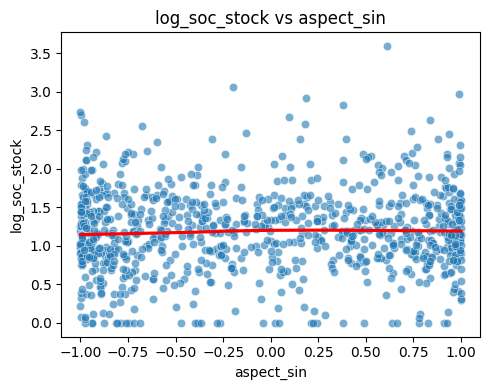

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


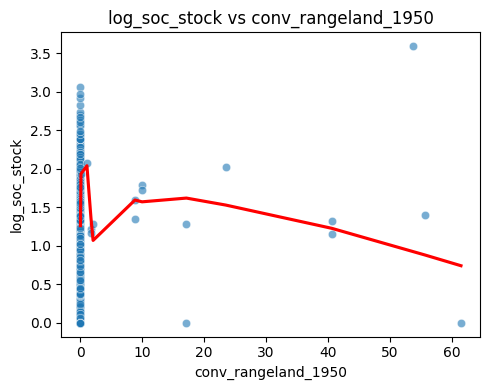

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


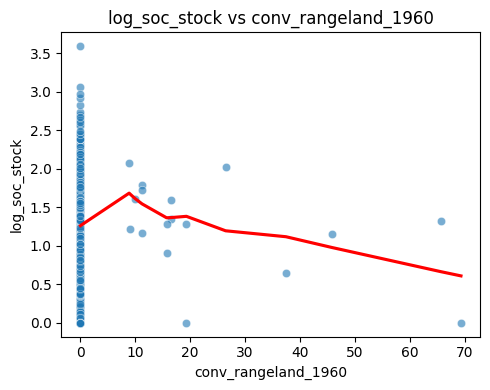

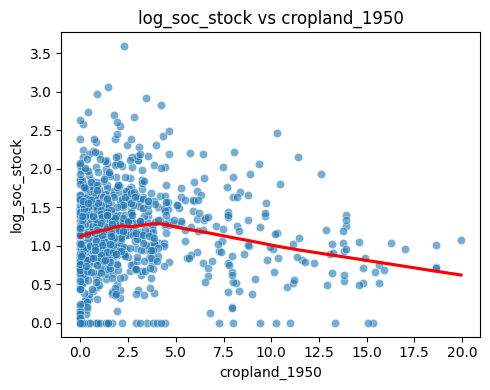

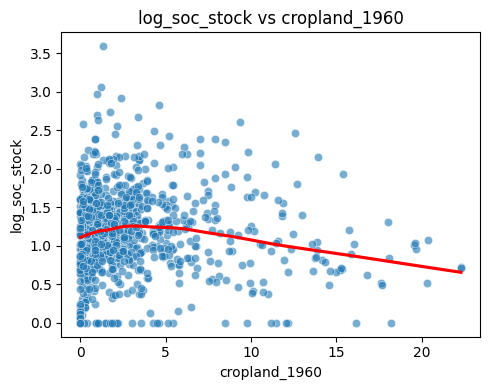

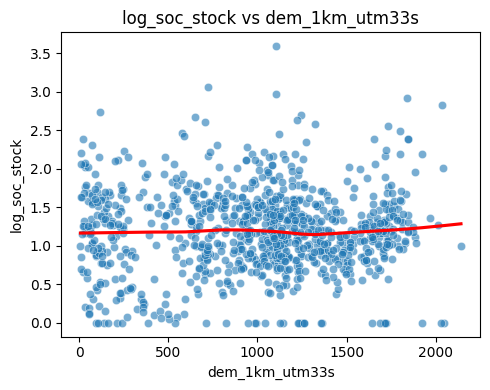

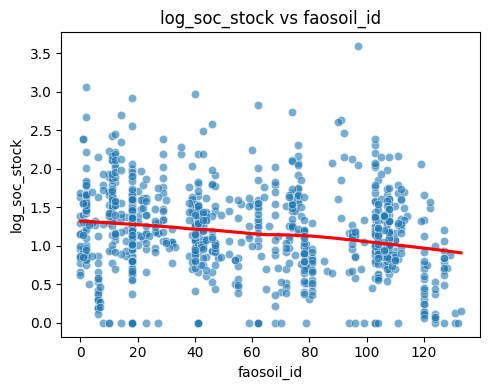

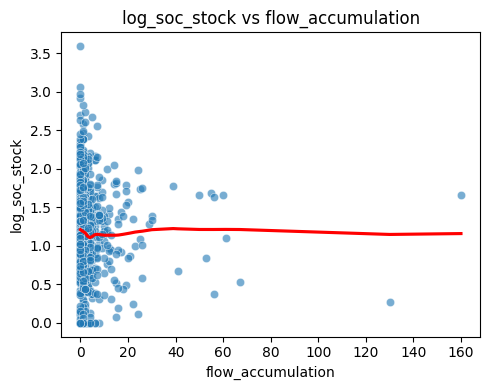

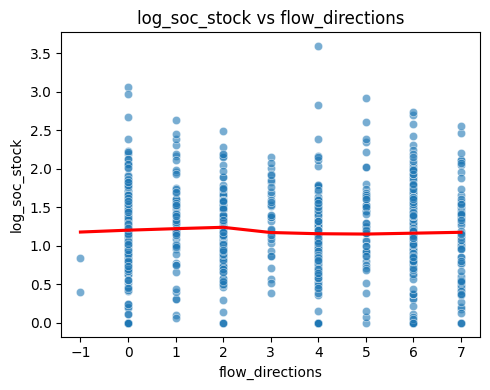

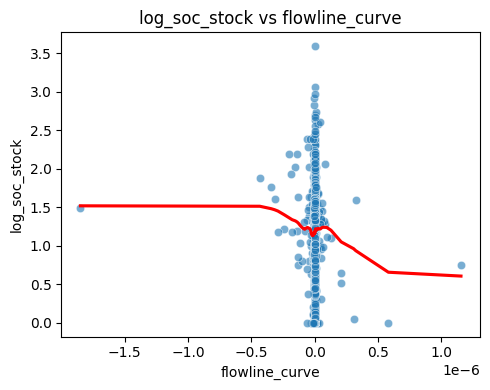

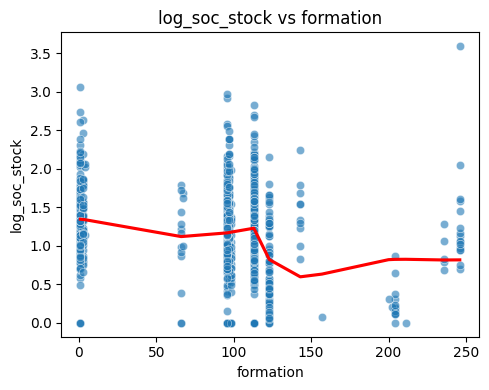

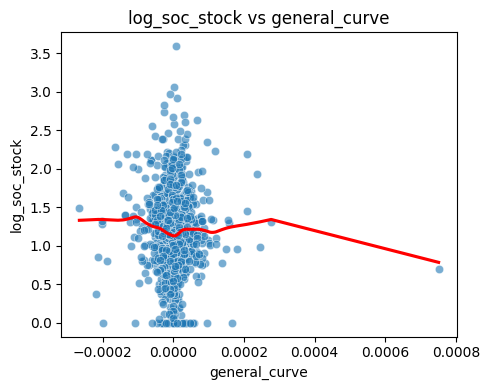

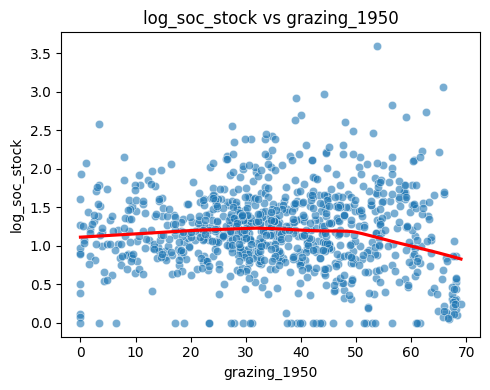

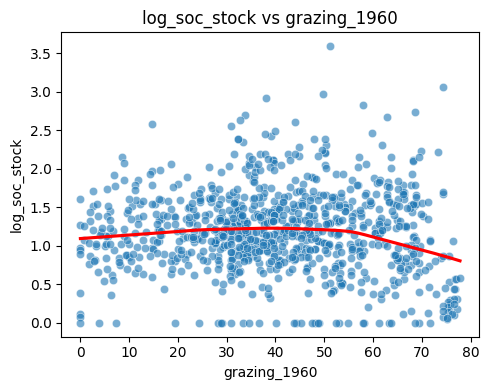

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


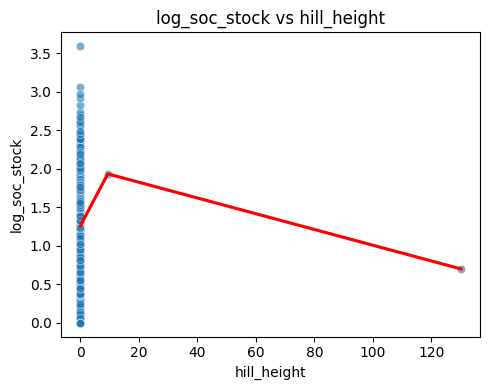

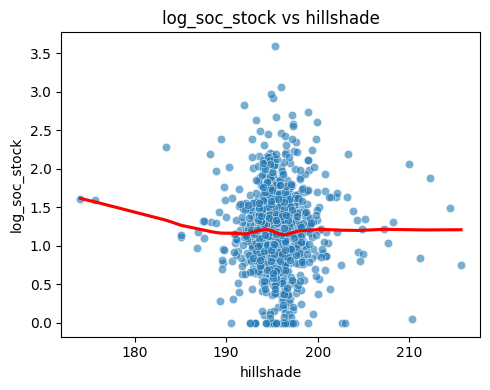

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


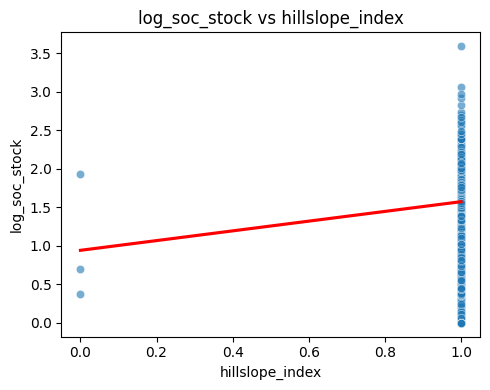

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


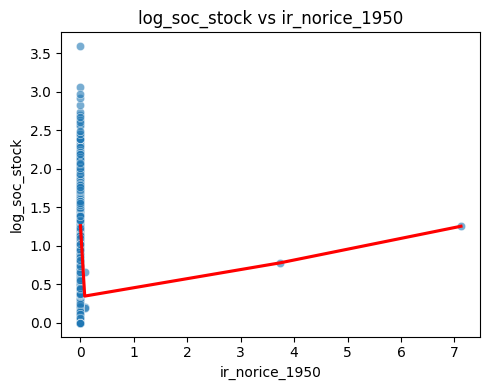

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


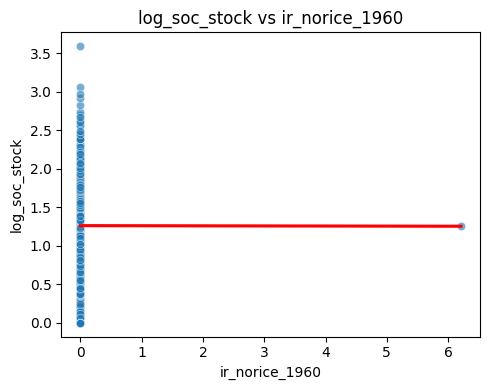

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


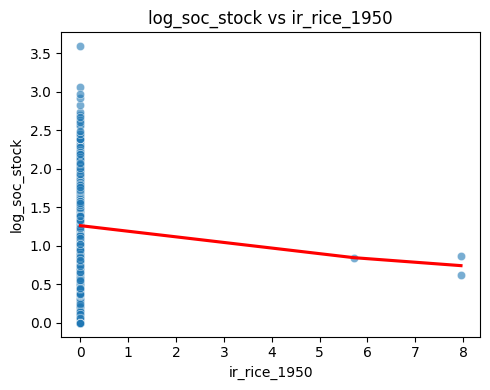

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


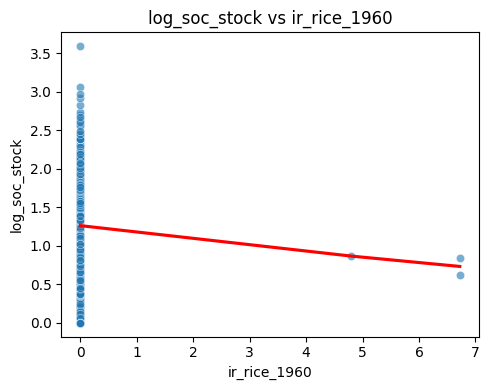

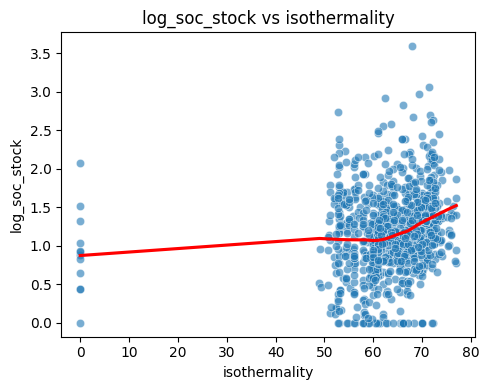

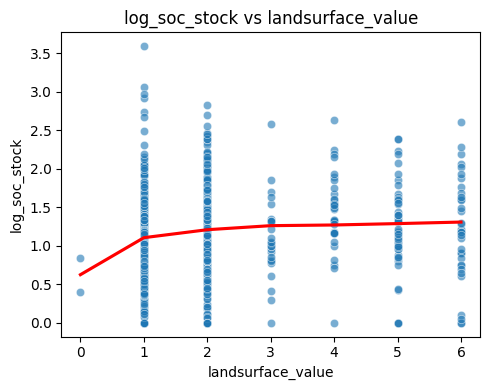

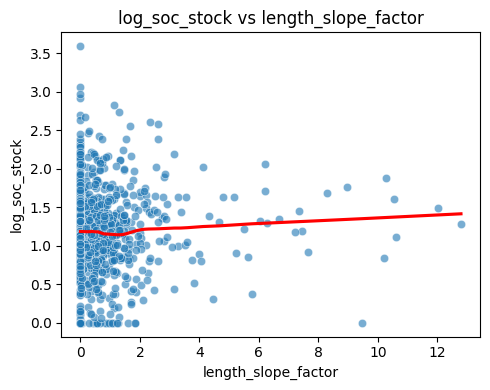

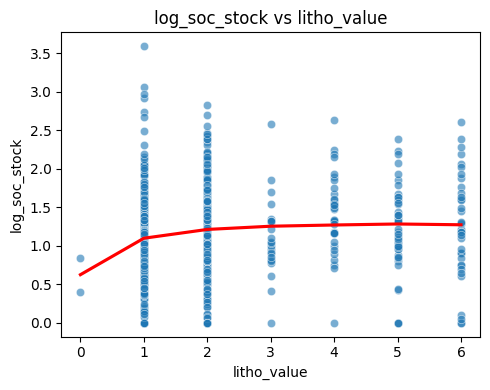

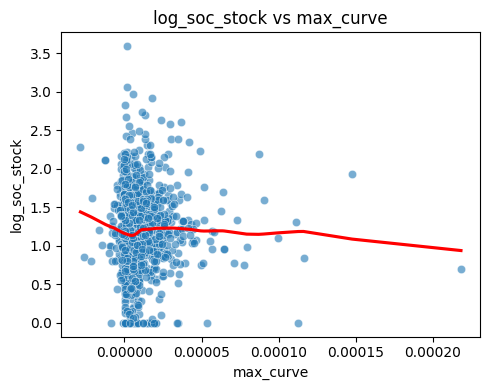

ValueError: Data must be 1-dimensional, got ndarray of shape (907, 2) instead

<Figure size 500x400 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check which numeric columns exist in df1
numeric_cols_existing = [col for col in numeric_cols if col in df1.columns]

# Create scatter plots vs log_soc_stock
for col in numeric_cols_existing:
    plt.figure(figsize=(5,4))
    sns.scatterplot(data=df1, x=col, y='log_soc_stock', alpha=0.6)
    # Optional trend line (smoothed)
    sns.regplot(data=df1, x=col, y='log_soc_stock', scatter=False, lowess=True, color='red')
    
    plt.title(f"log_soc_stock vs {col}")
    plt.xlabel(col)
    plt.ylabel("log_soc_stock")
    plt.tight_layout()
    plt.show()
    plt.close()

In [9]:
# =========================================================
# 10  CORRELATION AND REDUNDANCY CHECK
# =========================================================
df_reduced = df1.copy()
corr_matrix = df_reduced.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"\nHighly correlated columns (>0.9): {high_corr}")

# Keep FAO/literature important ones regardless
keep_cols = ['site_info_id', 'annual_mean_temp', 'temp_annual_range', 'temp_seasonality', 'max_temp_warmest_month', 'annual_precip', 'tmax_mean_mean', 'twi', 'MRVBF', 'terrain_surf_convexity', 'terrain_surf_texture', 'normalized_height', 'slope_height', 'litho_value', 'max_temp_warmest_month','standardized_height', 'temp_annual_range']
high_corr = [c for c in high_corr if c not in keep_cols]

df_reduced = df_reduced.drop(columns=high_corr, errors='ignore')

print(f"\nDropped {len(high_corr)} redundant columns after correlation filtering.")


Highly correlated columns (>0.9): ['grazing_1960', 'ir_rice_1960', 'litho_value', 'max_temp_warmest_month', 'max_temp_warmest_month', 'mean_temp_driest_quarter', 'mean_temp_warmest_quarter', 'mean_temp_wettest_quarter', 'min_temp_coldest_month', 'precip_wettest_quarter', 'rf_norice_1950', 'rf_norice_1960', 'rf_rice_1960', 'site_info_id', 'slope', 'standardized_height', 'temp_annual_range', 'temp_annual_range', 'temp_seasonality', 'tmin_mean_mean', 'tot_irri_1960', 'tot_rainfed_1950', 'tot_rainfed_1960', 'tot_rice_1950', 'tot_rice_1960', 'watershed_basins']

Dropped 18 redundant columns after correlation filtering.


In [10]:
df_reduced.columns

Index(['log_soc_stock', 'MRRTF', 'MRVBF', 'X_coord', 'Y_coord',
       'annual_mean_temp', 'annual_precip', 'aspect', 'aspect_cos',
       'aspect_sin', 'conv_rangeland_1950', 'conv_rangeland_1960',
       'cropland_1950', 'cropland_1960', 'dem_1km_utm33s', 'faosoil_id',
       'flow_accumulation', 'flow_directions', 'flowline_curve', 'formation',
       'general_curve', 'grazing_1950', 'hill_height', 'hillshade',
       'hillslope_index', 'ir_norice_1950', 'ir_norice_1960', 'ir_rice_1950',
       'isothermality', 'landsurface_value', 'length_slope_factor',
       'litho_value', 'max_curve', 'max_temp_warmest_month',
       'max_temp_warmest_month', 'mean_temp_coldest_quarter',
       'midslope_position', 'min_curve', 'normalized_height', 'pasture_1950',
       'pasture_1960', 'plan_curve', 'precip_coldest_quarter',
       'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
       'precip_sum', 'precip_warmest_quarter', 'precip_wettest_month',
       'profile_curve', 

In [11]:
df_reduced.isna().sum().sort_values(ascending=False)


log_soc_stock            0
precip_driest_quarter    0
rangeland_1950           0
profile_curve            0
precip_wettest_month     0
                        ..
landsurface_value        0
length_slope_factor      0
litho_value              0
max_curve                0
year                     0
Length: 70, dtype: int64

In [12]:
# =========================================================
# 11️  MULTICOLLINEARITY (VIF)
# =========================================================
continuous_cols = [c for c in df1.select_dtypes(include=[np.number]).columns 
                   if c not in [target_col, 'X_coord', 'Y_coord', 'site_info_id']]

X = df1[continuous_cols].dropna()
vif_df = pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)

print("\n📊 Variance Inflation Factors (VIF):")
print(vif_df)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



📊 Variance Inflation Factors (VIF):
                  variable       VIF
32  max_temp_warmest_month       inf
70       temp_annual_range       inf
69       temp_annual_range       inf
33  max_temp_warmest_month       inf
34  max_temp_warmest_month       inf
..                     ...       ...
72  terrain_surf_convexity  0.011937
74          tmax_mean_mean  0.004090
22         hillslope_index  0.003360
21               hillshade  0.000249
87                    year  0.000003

[88 rows x 2 columns]


In [13]:
df_reduced.columns

Index(['log_soc_stock', 'MRRTF', 'MRVBF', 'X_coord', 'Y_coord',
       'annual_mean_temp', 'annual_precip', 'aspect', 'aspect_cos',
       'aspect_sin', 'conv_rangeland_1950', 'conv_rangeland_1960',
       'cropland_1950', 'cropland_1960', 'dem_1km_utm33s', 'faosoil_id',
       'flow_accumulation', 'flow_directions', 'flowline_curve', 'formation',
       'general_curve', 'grazing_1950', 'hill_height', 'hillshade',
       'hillslope_index', 'ir_norice_1950', 'ir_norice_1960', 'ir_rice_1950',
       'isothermality', 'landsurface_value', 'length_slope_factor',
       'litho_value', 'max_curve', 'max_temp_warmest_month',
       'max_temp_warmest_month', 'mean_temp_coldest_quarter',
       'midslope_position', 'min_curve', 'normalized_height', 'pasture_1950',
       'pasture_1960', 'plan_curve', 'precip_coldest_quarter',
       'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
       'precip_sum', 'precip_warmest_quarter', 'precip_wettest_month',
       'profile_curve', 

In [14]:
## dropping rice columns bc not usefule

rice_columns = [
    'rf_norice_1950', 'rf_norice_1960',
    'rf_rice_1950', 'rf_rice_1960',
    'tot_rice_1950', 'tot_rice_1960', 
    'ir_rice_1950', 'ir_rice_1960',
    'ir_norice_1950', 'ir_norice_1960'
]

df_reduced = df_reduced.drop(columns=rice_columns)


KeyError: "['rf_norice_1950' 'rf_norice_1960' 'rf_rice_1950' 'rf_rice_1960'\n 'tot_rice_1950' 'tot_rice_1960' 'ir_rice_1950' 'ir_rice_1960'\n 'ir_norice_1950' 'ir_norice_1960'] not found in axis"

In [15]:
existing_rice_cols = [c for c in rice_columns if c in df_reduced.columns]
print(f"Dropping {len(existing_rice_cols)} rice-related columns: {existing_rice_cols}")

df_reduced = df_reduced.drop(columns=existing_rice_cols)


Dropping 4 rice-related columns: ['rf_rice_1950', 'ir_rice_1950', 'ir_norice_1950', 'ir_norice_1960']


In [16]:
df_reduced.columns

Index(['log_soc_stock', 'MRRTF', 'MRVBF', 'X_coord', 'Y_coord',
       'annual_mean_temp', 'annual_precip', 'aspect', 'aspect_cos',
       'aspect_sin', 'conv_rangeland_1950', 'conv_rangeland_1960',
       'cropland_1950', 'cropland_1960', 'dem_1km_utm33s', 'faosoil_id',
       'flow_accumulation', 'flow_directions', 'flowline_curve', 'formation',
       'general_curve', 'grazing_1950', 'hill_height', 'hillshade',
       'hillslope_index', 'isothermality', 'landsurface_value',
       'length_slope_factor', 'litho_value', 'max_curve',
       'max_temp_warmest_month', 'max_temp_warmest_month',
       'mean_temp_coldest_quarter', 'midslope_position', 'min_curve',
       'normalized_height', 'pasture_1950', 'pasture_1960', 'plan_curve',
       'precip_coldest_quarter', 'precip_driest_month',
       'precip_driest_quarter', 'precip_seasonality', 'precip_sum',
       'precip_warmest_quarter', 'precip_wettest_month', 'profile_curve',
       'rangeland_1950', 'rangeland_1960', 'relief_TRI', 's

In [17]:
df_reduced.shape

(907, 66)

In [18]:
# =========================================================
# 13️  FINAL EXPORT
# =========================================================
final_path = "/Users/inesschwartz/Desktop/final_training_dataset1.csv"
df_reduced.to_csv(final_path, index=False)
print(f"\n🎯 Ready-to-train dataset saved at: {final_path}")


🎯 Ready-to-train dataset saved at: /Users/inesschwartz/Desktop/final_training_dataset1.csv
